In [3]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns

from datetime import date, timedelta


In [56]:
date = date.today() - timedelta(days = 7)
print(date)

2020-08-12


일주일 전 같은 요일 대상 가장 많이 노출된 키워드(ref_term) 1000개 기준  
노출된 사용자의 나이, 성별

In [65]:
q = '''
SELECT i.imp_id,
       i.ref_term,
       t.imp_cnt,
       i.device_type,
       CASE
           WHEN u.sex = 1 THEN 'female'
           WHEN u.sex = 2 THEN 'male'
           ELSE 'none'
       END AS sex,
       Coalesce(NULL, Ceil((Extract(DAY
                                    FROM Getdate() - u.birthdate :: timestamptz) / 365.25)), 0) AS age_detail
FROM bun_log_db.app_event_type_impression i
JOIN
  (SELECT ref_term,
          count(*) AS imp_cnt
   FROM bun_log_db.app_event_type_impression
   WHERE ref_term IS NOT NULL
     AND device_type IN ('a',
                         'i')
     AND YEAR||MONTH||DAY = '20200810'
   GROUP BY 1
   ORDER BY count(*) DESC
   LIMIT 1000) t ON i.ref_term = t.ref_term
JOIN service1_quicket.user_extra_info u ON i.user_id = u.uid
WHERE i.year||i.month||i.day = '20200810'
  AND i.device_type IN ('a',
                        'i')
  AND u.is_identification = 1
  AND To_date(u.birthdate, 'YYYY-MM-DD') between '1930-01-01' and '2010-12-31'
'''.format('\'' + date.strftime('%Y%m%d') + '\'', '\'' + date.strftime('%Y%m%d') + '\'')

df = pd.read_sql(q, con=bun_dw)

In [59]:
# df.to_csv('df.csv', index=False)

In [60]:
df.head()

,ref_term,imp_cnt,device_type,sex,age_detail,age
0,280,73539,a,male,39.0,30
1,플레따,19730,i,female,24.0,20
2,327,51838,a,male,31.0,30
3,원피스,410746,a,female,31.0,30
4,스투시,171450,i,female,21.0,20


In [61]:
print('female:', df[df['sex'] == 'female'].shape[0]/df.shape[0]*100)
print('male:', df[df['sex'] == 'male'].shape[0]/df.shape[0]*100)
print('none:', df[df['sex'] == 'none'].shape[0]/df.shape[0]*100)

female: 42.79912025089407
male: 55.98956543304205
none: 1.2113143160638788


In [62]:
print('android:', df[df['device_type'] == 'a'].shape[0]/df.shape[0]*100)
print('iphone:', df[df['device_type'] == 'i'].shape[0]/df.shape[0]*100)

android: 51.26416448742286
iphone: 48.73583551257713


In [63]:
df['age_detail'] = df['age_detail'].astype(int)
df['age_detail'].describe()

count    1.395170e+07
mean     2.755752e+01
std      9.356760e+00
min      1.100000e+01
25%      2.100000e+01
50%      2.700000e+01
75%      3.000000e+01
max      9.100000e+01
Name: age_detail, dtype: float64

In [68]:
print('10:', df[df['age'] == 10].shape[0]/df.shape[0]*100)
print('20:', df[df['age'] == 20].shape[0]/df.shape[0]*100)
print('30:', df[df['age'] == 30].shape[0]/df.shape[0]*100)
print('40:', df[df['age'] == 40].shape[0]/df.shape[0]*100)

10: 17.805826631483164
20: 55.614787884346164
30: 14.330092741674688
40: 12.249292742495987


In [73]:
from sklearn.linear_model import LinearRegression
import numpy as np

x = np.array(df['age_detail']).reshape((-1, 1))
y = np.array(df['imp_cnt'])
lr = LinearRegression()
lr.fit(x, y)
print('coefficient of determination:', lr.score(x, y))

coefficient of determination: 0.00010297601925890465


In [76]:
print(lr.intercept_)
print(lr.coef_)

79758.48750199807
[-93.08918924]


In [124]:
keywords = df['ref_term'].unique()

In [362]:
keywords_df = df.groupby('ref_term', as_index=False)['imp_cnt'].count().sort_values('imp_cnt', ascending=False).reset_index()

In [363]:
keywords_df.head()

,index,ref_term,imp_cnt
0,175,나이키,196007
1,725,원피스,194446
2,620,아이폰,170246
3,820,카드지갑,148864
4,135,구찌,132215


In [368]:
keywords_df[keywords_df['ref_term'] == '나이키'].index[0]

0

In [370]:
keywords_df[keywords_df['ref_term'] == '나이키']['imp_cnt'][0]

196007

In [323]:
df.groupby('device_type')['imp_id'].agg(lambda x: len(x)/len(df))

device_type
a    0.508672
i    0.491328
Name: imp_id, dtype: float64

In [327]:
keyword_rank = df.groupby('ref_term', as_index=False)['imp_cnt'].count().sort_values('imp_cnt', ascending=False)['ref_term'].tolist()

In [340]:
keyword_rank.index('나이키에어맥스97') + 1

521

In [341]:
len(keyword_rank)

994

# Regression from sampling

In [334]:
l = ['아이폰 11',
'나이키 에어맥스 97',
'스투시',
'구찌',
'에어팟프로',
'갤럭시',
'갤럭시',
'루이비통가방',
'아이패드 프로',
'아이패드 에어3',
'게이밍 노트북',
'구찌시계',
'애플워치',
'애플워치',
'꼼데가르송 반팔',
'꼼데가르송 가디건',
'반지',
'가방',
'샤넬가방',
'맥북프로',
'닌텐도 스위치 라이트',
'자라 원피스',
'후드티',
'후드집업',
'스피커',
'뉴발란스 327',
'방탄',
'방탄',
'모자',
'롤 스킨']

for i in l:
    if i in keyword_rank:
        print(keyword_rank.index(i)+1)
    elif i+' ' in keyword_rank:
        print(keyword_rank.index(i+' ')+1)
    else: 
        print()

244

11
5
30
111
111
169
269
89
508
179
877
877
117
229
140
40
312
368
200
184
41
158
590
864
849
849
129
520


In [343]:
rank1= [3,
1,
1,
4,
7,
36,
50,
40,
21,
21,
9,
6,
92,
162,
113,
113,
120,
5,
40,
126,
97,
12,
1,
1,
293,
489,
714,
213,
53,
127]

rank2 = [244,
521,
11,
5,
30,
111,
111,
169,
269,
89,
508,
179,
877,
877,
117,
229,
140,
40,
312,
368,
200,
184,
41,
158,
590,
864,
849,
849,
129,
520]

diff = [x2-x1 for (x1, x2) in zip(rank1, rank2)]

In [347]:
perc = [90,
95,
54,
12,
56,
43,
31,
54,
77,
55,
89,
84,
94,
92,
3,
35,
9,
64,
71,
52,
34,
76,
76,
88,
41,
76,
46,
80,
35,
64]

In [348]:
from sklearn.linear_model import LinearRegression
import numpy as np

x = np.array(diff).reshape((-1, 1))
y = np.array(perc)
lr = LinearRegression()
lr.fit(x, y)
print('coefficient of determination:', lr.score(x, y))

coefficient of determination: 0.44794099946264543


In [349]:
print(lr.intercept_)
print(lr.coef_)

41.47784223206949
[0.08029976]


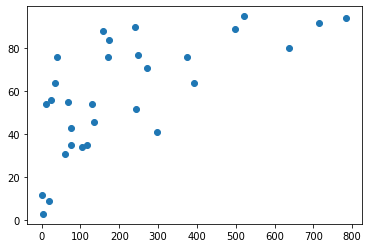

In [351]:
import matplotlib.pyplot as plt

plt.scatter(diff, perc)

In [356]:
np.polyfit(np.log(np.array(diff)), np.array([i/100 for i in perc]), 1)

array([0.12402657, 0.01155395])

# rank 1 & rank 2

In [359]:
keywords_dict = {}
for i in keywords:
    for j in keywords:
        if j in i:
            if i in keywords_dict:
                keywords_dict[i] += [j]
            else:
                keywords_dict[i] = [j]
keywords_dict

{'125': ['125'],
 '125cc': ['125cc', '125'],
 '14k': ['14k'],
 '14k 목걸이': ['14k', '목걸이', '14k 목걸이'],
 '14k귀걸이': ['14k', '귀걸이', '14k귀걸이'],
 '14k목걸이 ': ['14k', '목걸이', '14k목걸이 '],
 '14k반지': ['14k', '반지', '14k반지'],
 '14k팔찌': ['14k', '14k팔찌', '팔찌'],
 '18k': ['18k'],
 '18k목걸이': ['18k목걸이', '18k', '목걸이'],
 '18k팔찌': ['팔찌', '18k', '18k팔찌'],
 '18인치휠': ['18인치휠'],
 '19인치휠': ['19인치휠'],
 '240': ['240'],
 '245': ['245'],
 '250': ['250'],
 '260': ['260'],
 '265': ['265'],
 '270': ['270'],
 '275': ['275'],
 '280': ['280'],
 '285': ['285'],
 '290': ['290'],
 '327': ['327'],
 '87mm': ['87mm'],
 '98도씨': ['98도씨'],
 'acg ': ['acg '],
 'bmw': ['bmw'],
 'bmx': ['bmx'],
 'bt21': ['bt21'],
 'bts ': ['bts '],
 'cbr': ['cbr'],
 'cbr 125': ['cbr', '125', 'cbr 125'],
 'cbr125': ['cbr125', 'cbr', '125'],
 'cgv': ['cgv'],
 'cos ': ['cos '],
 'cp컴퍼니 ': ['cp컴퍼니 '],
 'gtx1060': ['gtx1060'],
 'h&m': ['h&m'],
 'iab ': ['iab '],
 'iab studio ': ['iab ', 'iab studio '],
 'iwc': ['iwc'],
 'k5': ['k5'],
 'k7': ['k7'],
 'lmc': 

In [384]:
keywords_cnt = {}
for keyword in keywords_dict:
    if len(keywords_dict[keyword]) > 1:
        for token in keywords_dict[keyword]:
            idx = keywords_df[keywords_df['ref_term'] == token].index[0]
            imp_cnt = keywords_df[keywords_df['ref_term'] == token]['imp_cnt'].values[0]
            if keyword in keywords_cnt:
                keywords_cnt[keyword][token] = (idx+1, imp_cnt)
            else:
                keywords_cnt[keyword] = {}
                keywords_cnt[keyword][token] = (idx+1, imp_cnt)

In [385]:
keywords_cnt

{'125cc': {'125': (812, 5210), '125cc': (404, 11623)},
 '14k 목걸이': {'14k': (15, 77527), '14k 목걸이': (838, 4320), '목걸이': (192, 20189)},
 '14k귀걸이': {'14k': (15, 77527), '14k귀걸이': (375, 12556), '귀걸이': (183, 20398)},
 '14k목걸이 ': {'14k': (15, 77527), '14k목걸이 ': (876, 1788), '목걸이': (192, 20189)},
 '14k반지': {'14k': (15, 77527), '14k반지': (366, 12811), '반지': (140, 24469)},
 '14k팔찌': {'14k': (15, 77527), '14k팔찌': (232, 18008), '팔찌': (103, 28602)},
 '18k목걸이': {'18k': (52, 40283), '18k목걸이': (713, 7124), '목걸이': (192, 20189)},
 '18k팔찌': {'18k': (52, 40283), '18k팔찌': (407, 11581), '팔찌': (103, 28602)},
 'cbr 125': {'125': (812, 5210), 'cbr': (553, 9292), 'cbr 125': (605, 8594)},
 'cbr125': {'125': (812, 5210), 'cbr': (553, 9292), 'cbr125': (136, 25031)},
 'iab studio ': {'iab ': (947, 440), 'iab studio ': (921, 779)},
 'mlb모자': {'mlb': (814, 5079), 'mlb모자': (517, 9839), '모자': (129, 26150)},
 'mtb자전거': {'mtb': (278, 15289), 'mtb자전거': (562, 9121)},
 'pcx125': {'125': (812, 5210), 'pcx': (73, 34904), 'pcx

## '아이폰' 이 들어가는 키워드

In [345]:
iphone = set()
for i in keywords:
    if '아이폰' in i:
        iphone.add(i)

print(iphone)


{'아이폰 11', '아이폰11프로', '아이폰', '아이폰11 케이스', '아이폰6s', '아이폰11 ', '아이폰8 ', '아이폰se2', '아이폰xr', '아이폰x ', '아이폰11pro', '아이폰 se  ', '아이폰xs max', '아이폰 se2', '아이폰7', '아이폰 xr', '아이폰8플러스 ', '아이폰xs', '아이폰se ', '아이폰 x', '아이폰6', '아이폰 xs '}


In [346]:
iphone11pro = df[df['ref_term'].isin(['아이폰 11', '아이폰11프로', '아이폰1', '아이폰'])]
iphone11pro.groupby('sex')['imp_id'].agg(lambda x: len(x)/len(iphone11pro)*100)

sex
female    25.810141
male      73.812945
none       0.376914
Name: imp_id, dtype: float64

In [179]:
iphone_rank = iphone_temp[iphone_temp['ref_term'].isin(['아이폰 11', '아이폰11프로', '아이폰11 ', '아이폰'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
iphone_rank


,ref_term,imp_id
0,아이폰,164303
1,아이폰 11,16455
3,아이폰11프로,13834
2,아이폰11,2453


In [180]:
(164303-16455)/164303*100


89.98496679914548

## '나이키'

In [125]:
nike = set()
for i in keywords:
    if 'nike' in i or '나이키' in i:
        nike.add(i)
print(nike)

{'나이키 운동화', '나이키 모자', '나이키 스투시 ', '나이키 조거팬츠', '나이키 바지', '나이키 오프화이트 ', '나이키 아노락', '나이키 맨투맨', '나이키 신발', '나이키 베이퍼맥스', '나이키 반팔', '나이키바람막이', '나이키 테크팩', '나이키 윈드러너', '나이키에어맥스97', '나이키 더블스우시 ', '나이키 에어포스', '나이키 후드집업', '나이키 후드티', '나이키 슬리퍼', '나이키 바람막이', '나이키 에어맥스', '나이키운동화 ', '나이키 데이브레이크', '나이키', '나이키 에어로로프트', '나이키모자', '나이키 반바지', '나이키 사카이 ', '나이키반바지'}


In [120]:
nike_airmax = df[df['ref_term'].isin(['나이키', '나이키에어맥스97', '나이키 에어맥스', '에어맥스', '나이키에어맥스'])]
nike_airmax.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,나이키,194465
2,나이키에어맥스97,9669
1,나이키 에어맥스,4285


In [136]:
nike_airmax.groupby('sex')['imp_id'].agg(lambda x: len(x)/len(nike_airmax))

sex
female    0.130960
male      0.854436
none      0.014605
Name: imp_id, dtype: float64

In [118]:
print((194465-9669)/194465)
print((9669-4285)/9669)

0.9502789705088319
0.5568311097321337


In [131]:
nike_stussy = df[df['ref_term'].isin(['나이키', '스투시', '나이키 스투시 ', '스투시 나이키'])]
nike_stussy.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,나이키,194465
2,스투시,89586
1,나이키 스투시,1939


In [137]:
nike_stussy.groupby('sex')['imp_id'].agg(lambda x: len(x)/len(nike_stussy))

sex
female    0.169862
male      0.812194
none      0.017945
Name: imp_id, dtype: float64

## '지갑'

In [139]:
wallet = set()
for i in keywords:
    if '지갑' in i:
        wallet.add(i)
print(wallet)

{'장지갑', '루이비통 카드지갑', '루이까또즈 반지갑', '지갑', '루이비통 장지갑', '프라다 카드지갑', '구찌 반지갑', '디올 카드지갑', '발렌티노 카드지갑', '샤넬 카드지갑', '구찌지갑 ', '입생로랑 카드지갑', '구찌 지갑', '루이비통 반지갑', '카드지갑', '반지갑', '동전지갑', '고야드 카드지갑', '루이비통지갑', '마르지엘라 카드지갑', '구찌 카드지갑', '루이비통 지갑'}


In [140]:
gucci_wallet = df[df['ref_term'].isin(['구찌', '카드지갑', '지갑', '구찌 카드지갑', '구찌 지갑'])]

In [142]:
gucci_wallet_cnt = gucci_wallet.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
gucci_wallet_cnt

,ref_term,imp_id
3,카드지갑,147895
0,구찌,130880
2,지갑,89848
1,구찌 카드지갑,23263


In [148]:
p = []
gucci_wallet_cnt['imp_id'] = gucci_wallet_cnt['imp_id'].astype(int)
t = gucci_wallet_cnt['imp_id'].tolist()
for i in range(1, 4):
    p.append((t[i-1]-t[i])/t[i-1])
p

[0.11504783799317084, 0.31350855745721273, 0.7410849434600659]

In [151]:
gucci_wallet.groupby('sex')['imp_id'].agg(lambda x: len(x)/len(gucci_wallet))

sex
female    0.397217
male      0.588859
none      0.013924
Name: imp_id, dtype: float64

## '에어팟'

In [152]:
a = set()
for i in keywords:
    if '에어팟' in i or 'airpods' in i:
        a.add(i)
print(a)

{'에어팟프로 케이스', '에어팟2', '에어팟프로', '에어팟 프로 ', '에어팟 프로 케이스', '에어팟 케이스', '에어팟케이스', '에어팟', '에어팟1', '에어팟 프로 미개봉'}


In [153]:
airpods_pro = df[df['ref_term'].isin(['에어팟프로', '에어팟 프로 ', '에어팟'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
airpods_pro

,ref_term,imp_id
0,에어팟,117979
2,에어팟프로,51504
1,에어팟 프로,1869


In [154]:
p = []
t = airpods_pro['imp_id'].astype(int).tolist()
for i in range(1, 3):
    p.append((t[i-1]-t[i])/t[i-1])
p

[0.5634477322235313, 0.9637115563839702]

In [156]:
df[df['ref_term'].isin(['에어팟프로', '에어팟 프로 ', '에어팟'])].groupby('sex')['imp_id'].agg(lambda x: len(x)/len(df[df['ref_term'].isin(['에어팟프로', '에어팟 프로 ', '에어팟'])]))

sex
female    0.278817
male      0.714467
none      0.006715
Name: imp_id, dtype: float64

## '갤럭시'

In [159]:
g = set()
for i in keywords:
    if '갤럭시' in i:
        g.add(i)
print(g)

{'갤럭시탭', '갤럭시s20', '갤럭시폴드', '갤럭시s10', '갤럭시s9', '갤럭시z플립', '갤럭시워치', '갤럭시탭s6', '갤럭시 버즈 라이브 ', '갤럭시s8', '갤럭시 버즈 플러스', '갤럭시 버즈 ', '갤럭시노트10플러스', '갤럭시버즈', '갤럭시', '갤럭시버즈플러스', '갤럭시노트10'}


In [161]:
galaxy = df[df['ref_term'].isin(['갤럭시노트10플러스', '갤럭시노트10', '갤럭시', '노트10', '노트10플러스', '노트10 플러스'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
galaxy

,ref_term,imp_id
3,노트10,47778
0,갤럭시,27401
1,갤럭시노트10,20292
2,갤럭시노트10플러스,13758
4,노트10플러스,8271


In [162]:
p = []
t = galaxy['imp_id'].astype(int).tolist()
for i in range(1, 5):
    p.append((t[i-1]-t[i])/t[i-1])
p

[0.42649336514713887,
 0.25944308601875843,
 0.3219988172678888,
 0.39882250327082425]

In [164]:
buds = df[df['ref_term'].isin(['버즈', '버즈 ', '갤럭시 버즈 ', '갤럭시', '갤럭시버즈'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
buds

,ref_term,imp_id
3,버즈,39993
0,갤럭시,27401
2,갤럭시버즈,10999
1,갤럭시 버즈,1012


In [165]:
p = []
t = buds['imp_id'].astype(int).tolist()
for i in range(1, 4):
    p.append((t[i-1]-t[i])/t[i-1])
p

[0.3148550996424374, 0.5985912922886026, 0.9079916356032367]

## '가방'

In [167]:
b = set()
for i in keywords:
    if '가방' in i:
        b.add(i)
print(b)

{'입생로랑 가방', '버버리가방', '구찌가방', '서류가방', '프라다가방', '루이비통가방', '가방', '샤넬가방', '디올가방', '루이비통 가방', '메트로시티가방'}


In [168]:
louis = df[df['ref_term'].isin(['루이비통가방', '루이비통', '루이비통 ', '루이비통 가방', '가방'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)
louis

,ref_term,imp_id
0,가방,46513
3,루이비통가방,21420
2,루이비통 가방,6331
1,루이비통,4553


In [169]:
p = []
t = louis['imp_id'].astype(int).tolist()
for i in range(1, 4):
    p.append((t[i-1]-t[i])/t[i-1])
p

[0.5394835852342356, 0.7044351073762839, 0.28084030958774286]

## '아이패드'

In [171]:
ipad = set()
for i in keywords:
    if '아이패드' in i:
        ipad.add(i)
print(ipad)

{'아이패드', '아이패드 프로', '아이패드 7세대 ', '아이패드 프로 3세대', '아이패드 미니5', '아이패드 6세대', '아이패드 에어3'}


In [172]:
df[df['ref_term'].isin(ipad)].groupby('ref_term', as_index=False)['imp_cnt'].count().sort_values('imp_cnt', ascending=False)

,ref_term,imp_cnt
0,아이패드,68049
4,아이패드 에어3,30526
5,아이패드 프로,15616
6,아이패드 프로 3세대,10328
3,아이패드 미니5,8556
1,아이패드 6세대,7222
2,아이패드 7세대,222


In [177]:
df[df['ref_term'].isin(ipad)].groupby('sex', as_index=False).agg(lambda x: len(x)/len(df[df['ref_term'].isin(ipad)]))

,sex,imp_id,ref_term,imp_cnt,device_type,age_detail,age
0,female,0.371423,0.371423,0.371423,0.371423,0.371423,0.371423
1,male,0.620614,0.620614,0.620614,0.620614,0.620614,0.620614
2,none,0.007963,0.007963,0.007963,0.007963,0.007963,0.007963


## '노트북'

In [181]:
n = set()
for i in keywords:
    if '노트북' in i:
        n.add(i)
print(n)

{'노트북', '게이밍노트북 ', '게이밍 노트북'}


In [183]:
df[df['ref_term'].isin(n)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
2,노트북,88671
0,게이밍 노트북,9729
1,게이밍노트북,174


In [185]:
(9729-174)/9729*100

98.21153253160654

## '시계' / '워치'

In [188]:
w = set()
for i in keywords:
    if '시계' in i:
        w.add(i)
print(w)

{'시계', '카시오 시계', '빈티지시계', '남자시계', '구찌시계', '구찌 시계', '까르띠에시계', '로렉스시계'}


In [189]:
df[df['ref_term'].isin(w)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
6,시계,126736
1,구찌시계,20402
0,구찌 시계,12669
5,빈티지시계,9385
7,카시오 시계,6921
3,남자시계,6449
4,로렉스시계,6392
2,까르띠에시계,5499


0.37903146750318595

## '애플 워치'

In [194]:
a = set()
for i in keywords:
    if '애플' in i:
        a.add(i)
print(a)

{'애플펜슬', '애플워치4', '애플워치5', '애플워치3', '애플워치 '}


In [195]:
df[df['ref_term'].isin(a)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
1,애플워치3,30003
3,애플워치5,22463
4,애플펜슬,10425
2,애플워치4,9926
0,애플워치,1740


In [197]:
(22463-1740)/22463

0.922539286827227

## '꼼데가르송'

In [200]:
c = set()
for i in keywords:
    if '꼼데가르송' in i:
        c.add(i)
print(c)

{'꼼데가르송 반팔', '꼼데가르송 가디건', '꼼데가르송'}


In [201]:
df[df['ref_term'].isin(c)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,꼼데가르송,27517
2,꼼데가르송 반팔,26821
1,꼼데가르송 가디건,17933


In [204]:
(27517-17933)/27517*100

34.829378202565685

## '반지'

In [208]:
r = set()
for i in keywords:
    if '반지' in i:
        r.add(i)
print(r)

{'구찌 반지갑', '구찌 반지', '루이비통 반지갑', '14k반지', '크롬하츠 반지', '반지', '금반지', '반지갑', '루이까또즈 반지갑'}


In [212]:
c = set() # for chrome hearts
t = set() # for tom ford
for i in keywords:
    if '크롬하츠' in i:
        c.add(i)
    elif '톰포드' in i:
        t.add(i)
print(c)
print(t)

{'크롬하츠', '크롬하츠 반지', '크롬하츠 팔찌'}
set()


In [209]:
df[df['ref_term'].isin(['크롬하츠 반지', '반지', '크롬하츠'])].groupby('ref_term')['imp_id'].count()

ref_term
반지         24181
크롬하츠       26441
크롬하츠 반지     7401
Name: imp_id, dtype: int64

In [214]:
(24181-7401)/24181*100

69.39332533807536

## '가방'

In [216]:
b = set()
for i in keywords:
    if '가방' in i:
        b.add(i)
print(b)

{'입생로랑 가방', '버버리가방', '구찌가방', '서류가방', '프라다가방', '루이비통가방', '가방', '샤넬가방', '디올가방', '루이비통 가방', '메트로시티가방'}


In [217]:
df[df['ref_term'].isin(b)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,가방,46513
1,구찌가방,24925
4,루이비통가방,21420
7,샤넬가방,13647
6,버버리가방,11055
10,프라다가방,10706
5,메트로시티가방,7310
2,디올가방,6780
9,입생로랑 가방,6625
3,루이비통 가방,6331


In [218]:
df[df['ref_term'].isin(['구찌', '구찌 ', '구찌가방', '가방'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
1,구찌,130880
0,가방,46513
2,구찌가방,24925


In [221]:
df[df['ref_term'].isin(['샤넬', '샤넬 ', '샤넬가방', '가방'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,가방,46513
2,샤넬가방,13647
1,샤넬,7676


In [223]:
(13647-7676)/13647*100

43.75320583278376

## '맥북'

In [225]:
m = set()
for i in keywords:
    if '맥북' in i:
        m.add(i)
print(m)

{'맥북프로', '맥북'}


In [226]:
df[df['ref_term'].isin(m)].groupby('ref_term')['imp_id'].count()

ref_term
맥북      26309
맥북프로    12669
Name: imp_id, dtype: int64

In [227]:
(26309-12669)/26309*100

51.84537610703561

## '닌텐도'

In [230]:
n = set()
for i in keywords:
    if '닌텐도' in i:
        n.add(i)
print(n)

{'닌텐도', '닌텐도 스위치 라이트', '닌텐도 3ds', '닌텐도스위치 ', '닌텐도 스위치 ', '닌텐도 스위치 동물의숲 에디션'}


In [231]:
df[df['ref_term'].isin(n)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,닌텐도,28978
4,닌텐도 스위치 라이트,19195
3,닌텐도 스위치 동물의숲 에디션,15109
1,닌텐도 3ds,7679
5,닌텐도스위치,5518
2,닌텐도 스위치,2089


In [234]:
(5518-2089)/5518*100

62.14208046393621

## '자라 원피스'

In [235]:
z = set()
for i in keywords:
    if '자라' in i:
        z.add(i)
print(z)

{'자라원피스', '자라', '자라 원피스'}


In [236]:
df[df['ref_term'].isin(z)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,자라,84768
1,자라 원피스,20375
2,자라원피스,8000


In [238]:
(20375-8000)/20375*100

60.73619631901841

## '후드티'

In [239]:
h = set()
for i in keywords:
    if '후드' in i:
        h.add(i)
print(h)

{'아크메드라비 후드티', '스톤아일랜드 후드집업', '나이키 후드집업', '나이키 후드티', '후드티', '후드집업', '네이버후드 ', '오프화이트 후드티'}


In [240]:
df[df['ref_term'].isin(h)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
7,후드티,46722
6,후드집업,22759
1,나이키 후드티,19798
0,나이키 후드집업,12939
5,오프화이트 후드티,10210
3,스톤아일랜드 후드집업,9609
4,아크메드라비 후드티,8900
2,네이버후드,352


In [241]:
df[df['ref_term'].isin(['후드티', '나이키 ', '나이키', '나이키 후드티'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,나이키,194465
2,후드티,46722
1,나이키 후드티,19798


In [244]:
(46722-19798)/46722*100

57.6259577929027

In [242]:
df[df['ref_term'].isin(['후드집업', '나이키 ', '나이키', '나이키 후드집업'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,나이키,194465
2,후드집업,22759
1,나이키 후드집업,12939


In [246]:
(22759-12939)/22759*100

43.147765719056196

In [284]:
df.groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False).to_csv('keyword_cnt.csv', index=False)

## '스피커'

In [277]:
s = set()
for i in keywords:
    if '스피커' in i:
        s.add(i)
print(s)

{'스피커', '블루투스 스피커'}


In [278]:
df[df['ref_term'].isin(s)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
0,블루투스 스피커,14750
1,스피커,8748


In [279]:
(14750-8748)/14750*100

40.69152542372881

## '뉴발란스'

In [286]:
m = set()
for i in keywords:
    if '뉴발란스' in i:
        m.add(i)
print(m)

{'뉴발란스 ', '뉴발란스 327 ', '뉴발란스327'}


In [287]:
df[df['ref_term'].isin(m)].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
2,뉴발란스327,10030
1,뉴발란스 327,2412
0,뉴발란스,987


In [289]:
(2412-987)/2412*100

59.079601990049746

# 키워드 토큰

In [291]:
tokens = []
for i in keywords:
    tokens.append(i.split(' '))


In [292]:
long = []
for i in tokens:
    if len(i) > 1:
        long.append(i)

In [294]:
token_cnt = {}
for i in long:
    for j in i:
        if j in token_cnt:
            token_cnt[j] += 1
        else:
            token_cnt[j] = 1

In [302]:
del token_cnt['']

In [320]:
token_cnt

{'11': 1,
 '125': 1,
 '14k': 1,
 '14k목걸이': 1,
 '327': 1,
 '3ds': 1,
 '3세대': 1,
 '5g': 1,
 '6세대': 1,
 '7세대': 1,
 'acg': 1,
 'bts': 1,
 'cbr': 1,
 'cos': 1,
 'cp컴퍼니': 1,
 'iab': 2,
 'max': 1,
 'ps4': 1,
 's10': 1,
 's20': 1,
 'se': 1,
 'se2': 1,
 'sm5': 1,
 'studio': 1,
 'x': 1,
 'xr': 1,
 'xs': 1,
 '가디건': 4,
 '가방': 2,
 '가스건': 1,
 '가죽자켓': 1,
 '갤럭시': 3,
 '게이밍': 1,
 '게이밍노트북': 1,
 '겐조': 1,
 '계정': 3,
 '고비': 1,
 '고야드': 2,
 '골든구스': 1,
 '공기계': 1,
 '구찌': 8,
 '구찌지갑': 1,
 '귀멸의': 1,
 '귀멸의칼날': 1,
 '그래픽카드': 1,
 '기기': 1,
 '까르띠에': 1,
 '꼼데가르송': 2,
 '나이키': 24,
 '나이키운동화': 1,
 '널디': 1,
 '네이버후드': 1,
 '노스페이스': 2,
 '노트북': 1,
 '농구화': 1,
 '뉴발란스': 2,
 '니들스': 1,
 '니트': 2,
 '닉네임': 1,
 '닌텐도': 4,
 '닌텐도스위치': 1,
 '대구': 1,
 '더블스우시': 1,
 '더오픈프로덕트': 1,
 '덩크': 1,
 '데이브레이크': 2,
 '데이식스': 1,
 '동물의숲': 1,
 '드래곤볼': 2,
 '드바스크': 1,
 '디아이콘': 1,
 '디올': 3,
 '딕슨': 1,
 '라벨르블랑': 1,
 '라씨': 1,
 '라이브': 2,
 '라이톤': 1,
 '라이트': 1,
 '라코스테': 2,
 '라프시몬스': 1,
 '랜박': 1,
 '러브미우': 1,
 '러쉬플러스': 1,
 '럭키슈에뜨': 1,
 '런스타': 1,
 '레고': 1,
 '레디백': 1,
 '레인부츠':

In [303]:
token_dict = {}
for i in token_cnt.keys():
    for j in keywords:
        if i in j:
            if i in token_dict:
                token_dict[i].add(j)
            else:
                token_dict[i] = set()
                token_dict[i].add(j)

In [304]:
token_dict

{'11': {'아이폰 11', '아이폰11 ', '아이폰11 케이스', '아이폰11pro', '아이폰11프로', '엔진11 '},
 '125': {'125', '125cc', 'cbr 125', 'cbr125', 'pcx125', '보이져125'},
 '14k': {'14k', '14k 목걸이', '14k귀걸이', '14k목걸이 ', '14k반지', '14k팔찌'},
 '14k목걸이': {'14k목걸이 '},
 '327': {'327', '뉴발란스 327 ', '뉴발란스327'},
 '3ds': {'닌텐도 3ds'},
 '3세대': {'아이패드 프로 3세대'},
 '5g': {'s10 5g '},
 '6세대': {'아이패드 6세대'},
 '7세대': {'아이패드 7세대 '},
 'acg': {'acg '},
 'bts': {'bts '},
 'cbr': {'cbr', 'cbr 125', 'cbr125'},
 'cos': {'cos '},
 'cp컴퍼니': {'cp컴퍼니 '},
 'iab': {'iab ', 'iab studio '},
 'max': {'nmax', 'xmax', '아이폰xs max'},
 'ps4': {'ps4 '},
 's10': {'s10', 's10 5g ', '갤럭시s10'},
 's20': {'s20 ', '갤럭시s20'},
 'se': {'아이폰 se  ', '아이폰 se2', '아이폰se ', '아이폰se2'},
 'se2': {'아이폰 se2', '아이폰se2'},
 'sm5': {'sm5 '},
 'studio': {'iab studio '},
 'x': {'bmx',
  'gtx1060',
  'nmax',
  'pcx',
  'pcx125',
  'pxg',
  'xl',
  'xmax',
  'xxl',
  '아이폰 x',
  '아이폰 xr',
  '아이폰 xs ',
  '아이폰x ',
  '아이폰xr',
  '아이폰xs',
  '아이폰xs max'},
 'xr': {'아이폰 xr', '아이폰xr'},
 'xs': {'아

In [307]:
df[df['ref_term'].isin(token_dict['방탄'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
4,방탄 포카,18926
2,방탄 비공굿,7264
5,방탄소년단,7024
3,방탄 앨범,5349
6,방탄소년단 앨범,3918
0,방탄,3764
1,방탄 랜박,3520
7,방탄소년단 포카,3114
8,방탄포카,78


In [312]:
(3764-78)/3764*100

97.92773645058448

In [313]:
df[df['ref_term'].isin(['발렌시아가', '발렌시아가 모자', '모자'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
1,발렌시아가,39757
0,모자,25971
2,발렌시아가 모자,9784


In [315]:
(25971-9784)/25971*100

62.32721112009549

In [318]:
df[df['ref_term'].isin(token_dict['롤'])].groupby('ref_term', as_index=False)['imp_id'].count().sort_values('imp_id', ascending=False)

,ref_term,imp_id
4,롤렉스,31977
0,롤,25280
3,롤 스킨,9103
2,롤 닉네임,7314
1,롤 계정,1097
5,시나모롤,1022


## 나이별 노출


In [251]:
age = df['age_detail'].astype(int)

In [254]:
print(age.min())
print(age.max())

11
91


In [255]:
np.arange(1,3)

array([1, 2])

In [258]:
i = 11
age_group = {}
while i < 93:
    age_group[str(i)+'-'+str(i+3)] = np.arange(i,i+3)
    i += 3

In [261]:
age_count = {}
for key in age_group.keys():
    age_count[key] = 0

In [262]:
for i in age:
    for key in age_group.keys():
        if i in age_group[key]:
            age_count[key] += 1

In [263]:
age_count

{'11-14': 41038,
 '14-17': 701339,
 '17-20': 1859235,
 '20-23': 2061349,
 '23-26': 1953561,
 '26-29': 3778798,
 '29-32': 950750,
 '32-35': 594595,
 '35-38': 499956,
 '38-41': 560626,
 '41-44': 423107,
 '44-47': 379328,
 '47-50': 311251,
 '50-53': 219586,
 '53-56': 99860,
 '56-59': 68244,
 '59-62': 47160,
 '62-65': 27507,
 '65-68': 7799,
 '68-71': 4142,
 '71-74': 2248,
 '74-77': 4464,
 '77-80': 3610,
 '80-83': 6718,
 '83-86': 3670,
 '86-89': 12,
 '89-92': 1062,
 '92-95': 0}

In [264]:
n = len(age)
for i in age_count:
    age_count[i] = round(age_count[i]/n*100, 2)

In [265]:
age_count

{'11-14': 0.28,
 '14-17': 4.8,
 '17-20': 12.72,
 '20-23': 14.11,
 '23-26': 13.37,
 '26-29': 25.86,
 '29-32': 6.51,
 '32-35': 4.07,
 '35-38': 3.42,
 '38-41': 3.84,
 '41-44': 2.9,
 '44-47': 2.6,
 '47-50': 2.13,
 '50-53': 1.5,
 '53-56': 0.68,
 '56-59': 0.47,
 '59-62': 0.32,
 '62-65': 0.19,
 '65-68': 0.05,
 '68-71': 0.03,
 '71-74': 0.02,
 '74-77': 0.03,
 '77-80': 0.02,
 '80-83': 0.05,
 '83-86': 0.03,
 '86-89': 0.0,
 '89-92': 0.01,
 '92-95': 0.0}

In [274]:
df.head()

,imp_id,ref_term,imp_cnt,device_type,sex,age_detail,age
0,970a5f301685171d226a,니트조끼,19673,i,female,24.0,20
1,970a5f3019d91739272f,네일팁,27580,i,female,21.0,20
2,971b5f3010e616e6c9b4,스와로브스키 목걸이,16007,i,female,23.0,20
3,971b5f301af6173c2988,반지갑,58646,i,female,27.0,20
4,99e35f301b92173c59a6,원피스,410746,a,female,28.0,20
